Propagating wavelength 575.000 nm.
PSF calculated in 0.442s


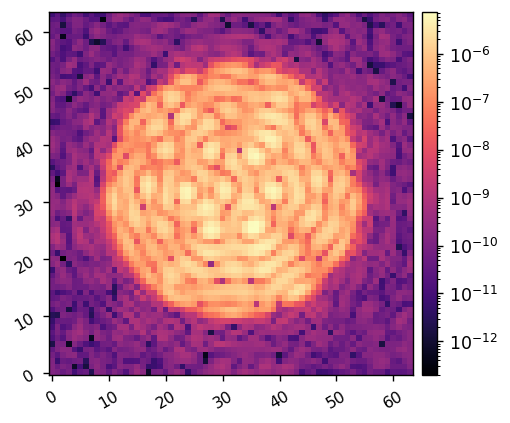

In [3]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import efc

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

reload(cgi)
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=True, use_fieldstop=True, 
                     return_intermediates=False, quiet=False,)
hlci.set_dm1(2*dm1_flatmap)
hlci.set_dm2(2*dm2_flatmap)

ref_psf = hlci.calc_psf()[-1]
misc.myimshow(ref_psf.intensity, lognorm=True)

npsf = hlci.npsf
Nact = hlci.Nact

(_calc_psf pid=91585) Propagating wavelength 575.000 nm.
All PSFs calculated in 0.515s
(_calc_psf pid=91585) PSF calculated in 0.444s


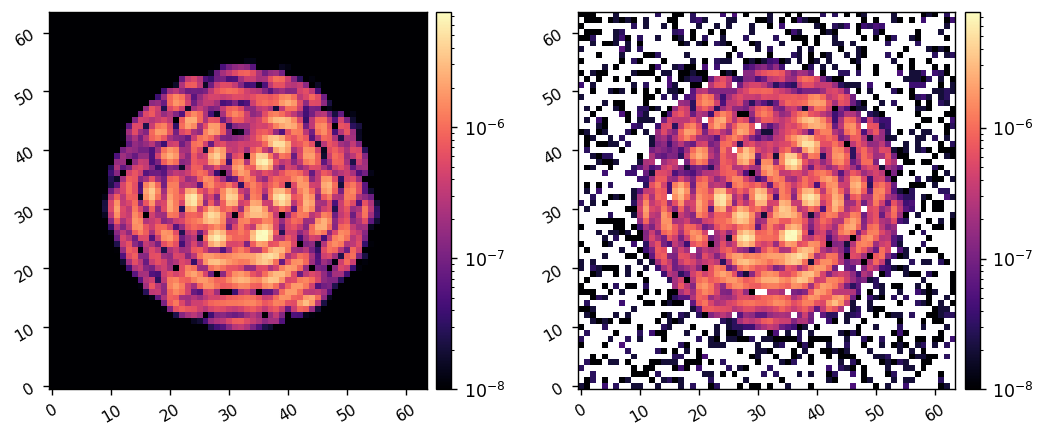

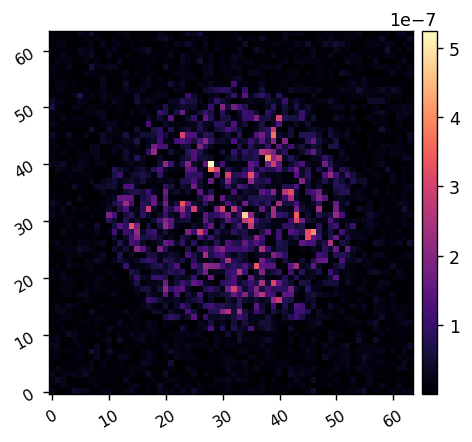

In [20]:
# hlci = init()

ref_psf = hlci.calc_psfs(ngpus=1)[0][-1]
noisy_psf = hlci.add_noise(ref_psf.intensity)

misc.myimshow2(ref_psf.intensity, noisy_psf, lognorm1=True, lognorm2=True, vmin1=1e-8, vmin2=1e-8)
misc.myimshow(abs(ref_psf.intensity-noisy_psf))

In [21]:
!nvidia-smi

Fri May 20 09:30:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |   7469MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create the dark-hole mask

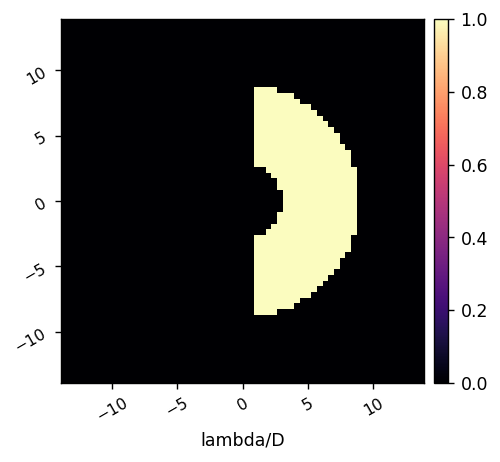

In [8]:
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 9

# Create the mask that is used to select which region to make dark.
dh_params = {'inner_radius' : iwa, 'outer_radius' : owa, 'edge_position' : edge, 'direction' : '+x'}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params)
nmask = dh_mask.sum()

misc.myimshow(dh_mask, pxscl=hlci.psf_pixelscale_lamD)

In [10]:
reload(efc)

jac = efc.build_jacobian(hlci, 1e-9, dh_mask)

Building Jacobian.
	Calculating response for mode 0. Elapsed time=0.000 sec.
	Calculating response for mode 1. Elapsed time=1.863 sec.
	Calculating response for mode 2. Elapsed time=2.556 sec.
	Calculating response for mode 3. Elapsed time=3.226 sec.
	Calculating response for mode 4. Elapsed time=3.890 sec.
	Calculating response for mode 5. Elapsed time=4.550 sec.
	Calculating response for mode 6. Elapsed time=5.207 sec.
	Calculating response for mode 7. Elapsed time=5.878 sec.
	Calculating response for mode 8. Elapsed time=6.536 sec.
	Calculating response for mode 9. Elapsed time=7.197 sec.
	Calculating response for mode 10. Elapsed time=7.852 sec.
	Calculating response for mode 11. Elapsed time=8.495 sec.
	Calculating response for mode 12. Elapsed time=9.136 sec.
	Calculating response for mode 13. Elapsed time=9.766 sec.
	Calculating response for mode 14. Elapsed time=10.405 sec.


KeyboardInterrupt: 

In [9]:
iefcu.save_pickle(data_dir/'jacobians'/'jac_opds_right39', jac, quiet=False)

NameError: name 'jac' is not defined

In [10]:
jac = iefcu.load_pickle(data_dir/'jacobians'/'jac_opds_right39')
jac.shape

(1044, 2304)

# Generate probes and test PWP

Generating probe with amplitude=2.875e-08, radius=12.0, phase=0.000, offset=(10.0,10.0), with discontinuity along x axis.


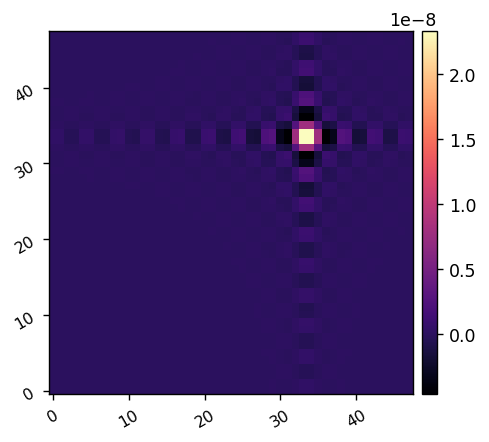

Generating probe with amplitude=2.875e-08, radius=12.0, phase=1.047, offset=(10.0,10.0), with discontinuity along y axis.


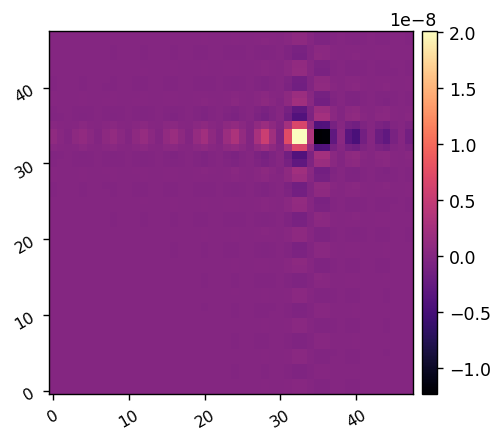

Generating probe with amplitude=2.875e-08, radius=12.0, phase=2.094, offset=(10.0,10.0), with discontinuity along x axis.


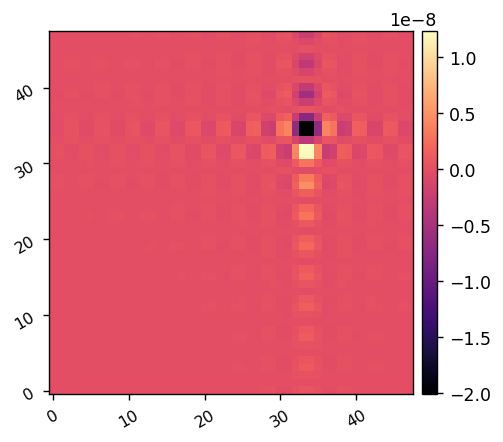

In [16]:
reload(efc)

Npairs = 3
probe_amp = 0.05*hlci.wavelength_c.value
probe_radius = 12
probe_offset = (10,10)

probes = efc.create_sinc_probes(Npairs, Nact, probe_amp, probe_radius, probe_offset, display=True)


(_calc_psf pid=91585) Propagating wavelength 575.000 nm.
(_calc_psf pid=91579) Propagating wavelength 575.000 nm.
(_calc_psf pid=91580) Propagating wavelength 575.000 nm.
(_calc_psf pid=91585) PSF calculated in 0.787s
All PSFs calculated in 0.957s
(_calc_psf pid=91579) PSF calculated in 0.791s
(_calc_psf pid=91580) PSF calculated in 0.754s
(_calc_psf pid=91579) Propagating wavelength 575.000 nm.
(_calc_psf pid=91580) Propagating wavelength 575.000 nm.
(_calc_psf pid=91585) Propagating wavelength 575.000 nm.
(_calc_psf pid=91580) PSF calculated in 0.776s
(_calc_psf pid=91579) PSF calculated in 0.751s
All PSFs calculated in 0.920s
(_calc_psf pid=91585) PSF calculated in 0.712s


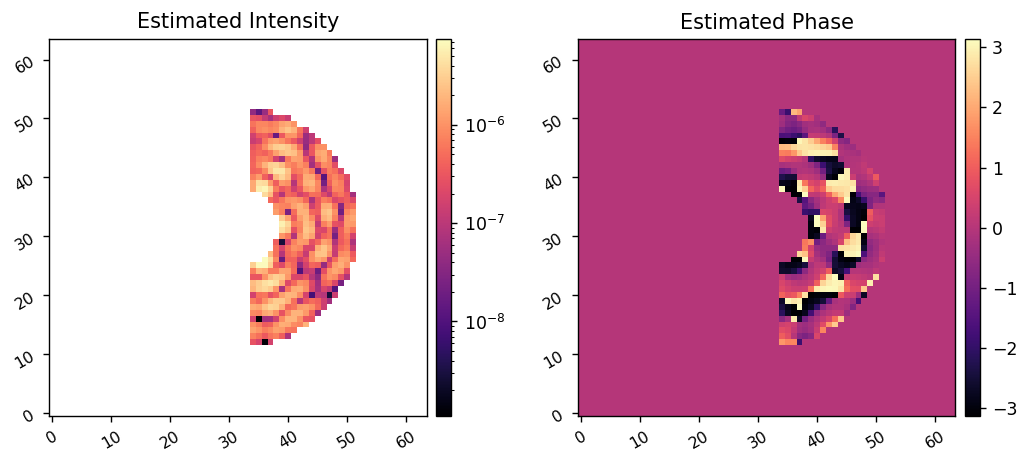

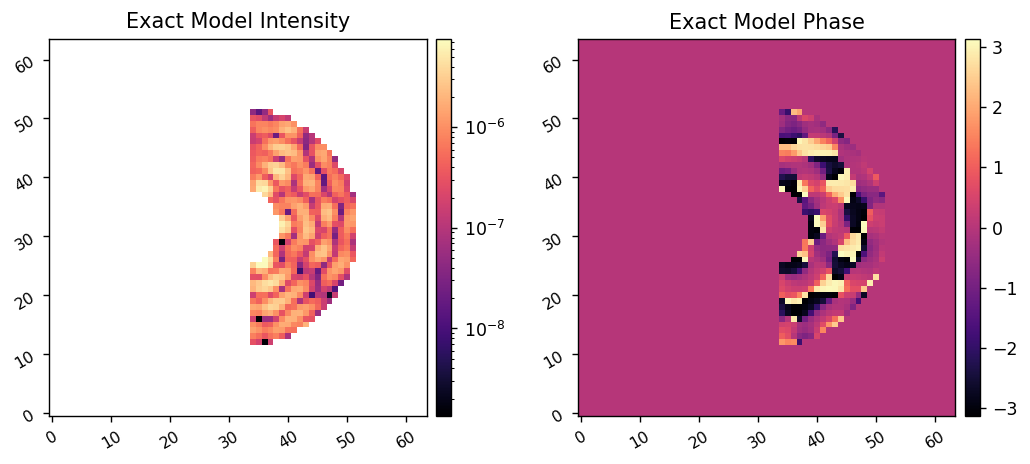

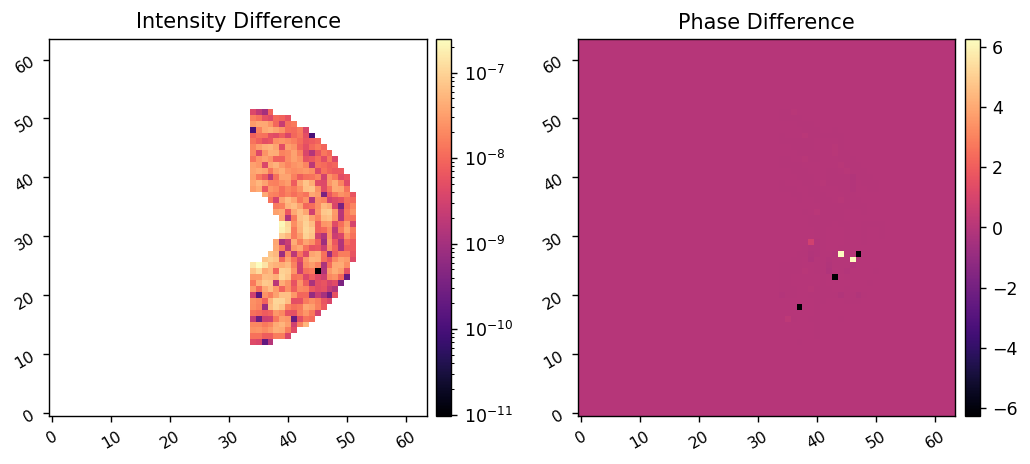

In [22]:
reload(efc)

E_est = efc.run_pwp(hlci, probes, jac, dh_mask, use_noise=False)

misc.myimshow2(cp.abs(E_est)**2, cp.angle(E_est), 
               'Estimated Intensity', 'Estimated Phase', lognorm1=True)
misc.myimshow2(ref_psf.intensity.get()*dh_mask, ref_psf.phase.get()*dh_mask, 
               'Exact Model Intensity', 'Exact Model Phase', lognorm1=True)
misc.myimshow2(abs(ref_psf.intensity - cp.abs(E_est)**2).get()*dh_mask, 
               (ref_psf.phase - cp.angle(E_est)).get()*dh_mask,
               'Intensity Difference', 'Phase Difference',
               lognorm1=True)

# Invert the Jacobian to get the control matrix

In [25]:
control_matrix = iefcu.TikhonovInverse(jac, 5e-2)
control_matrix.shape

(2304, 1044)

# Run EFC with perfect model

Beginning closed-loop EFC simulation.
	Running iteration 1/10.


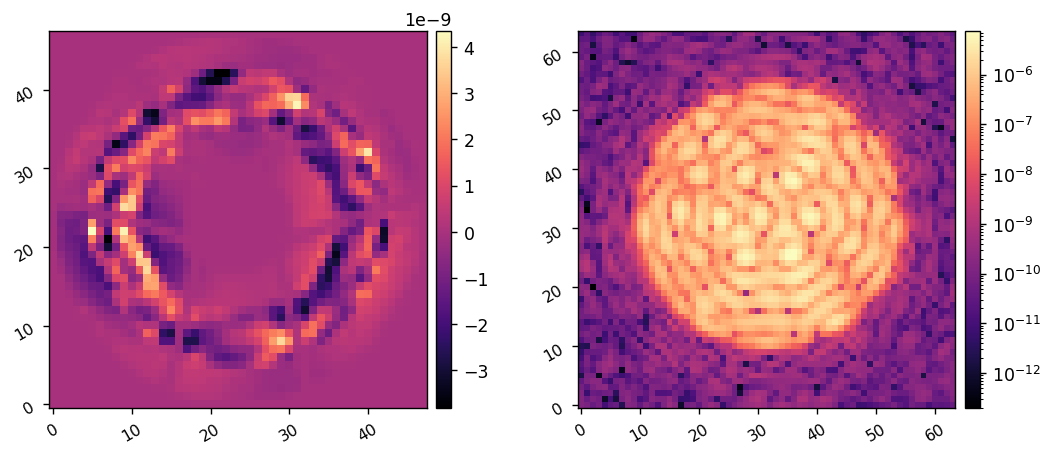

	Running iteration 2/10.


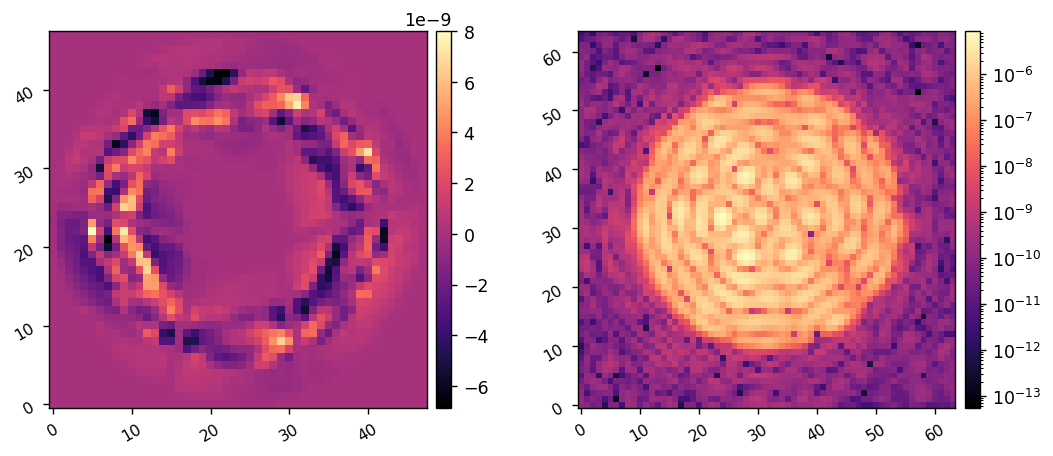

	Running iteration 3/10.


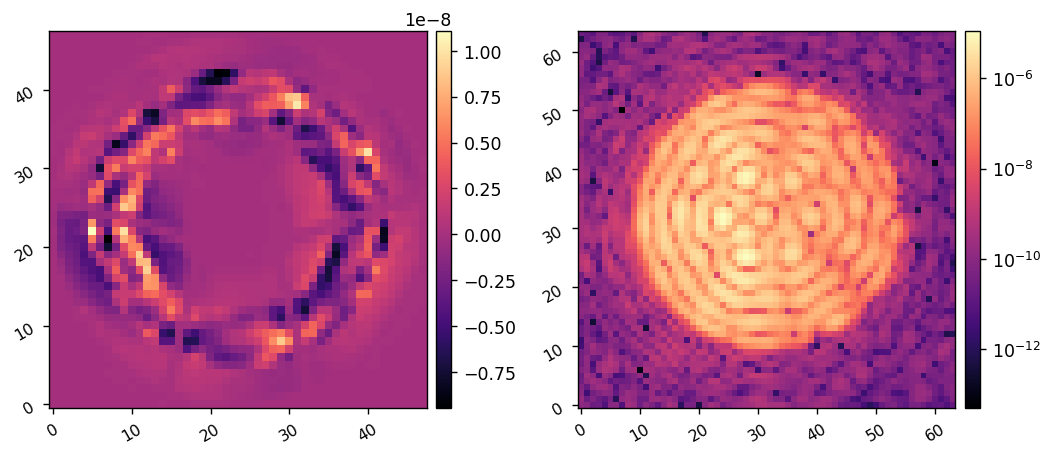

	Running iteration 4/10.


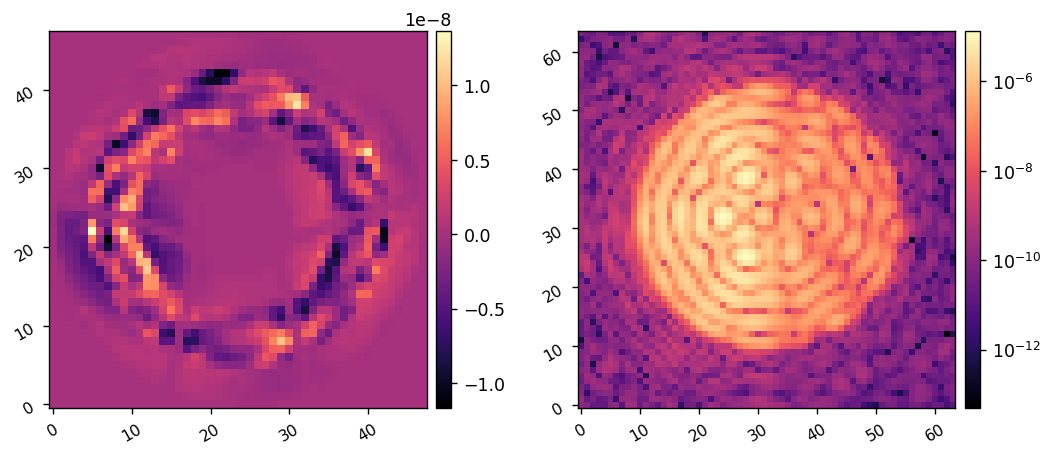

	Running iteration 5/10.


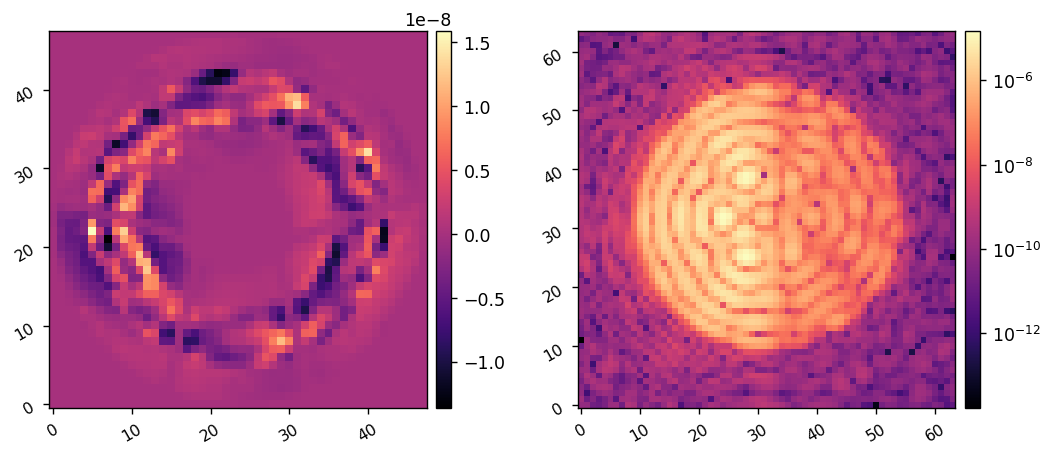

	Running iteration 6/10.


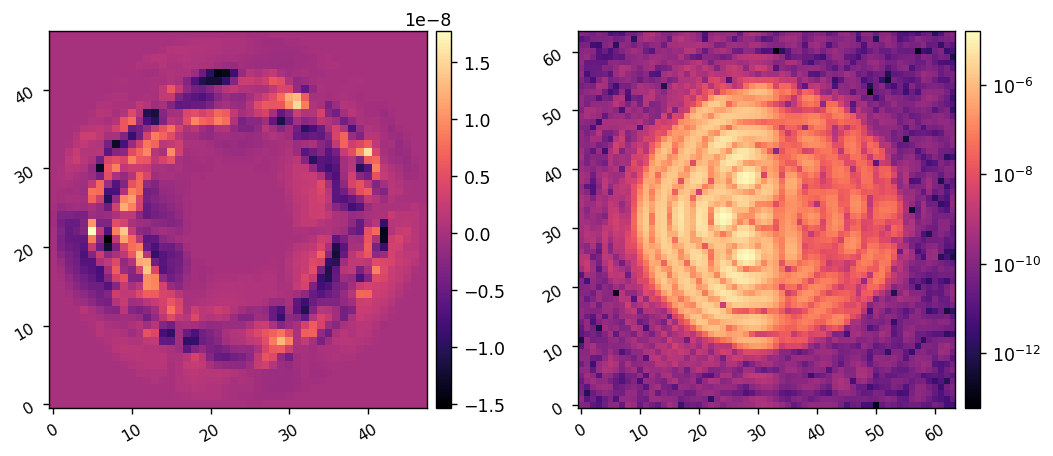

	Running iteration 7/10.


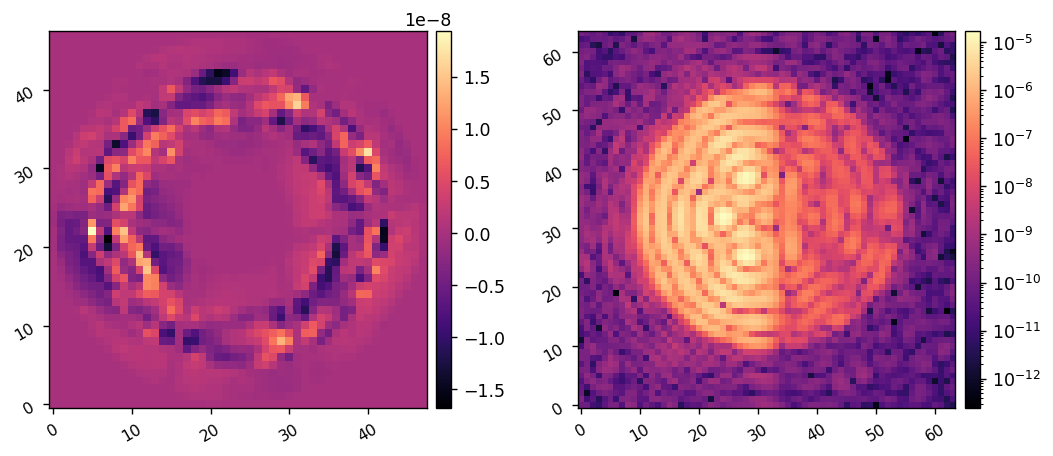

	Running iteration 8/10.


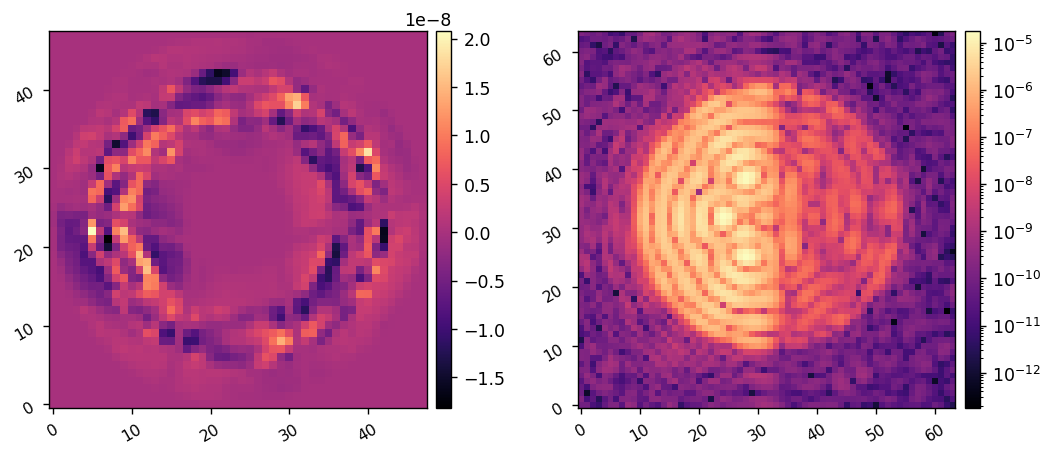

	Running iteration 9/10.


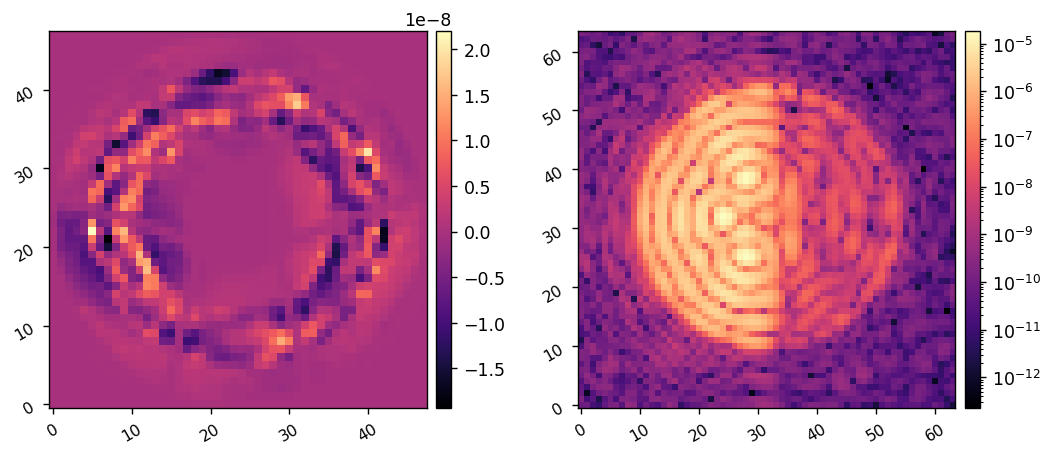

	Running iteration 10/10.


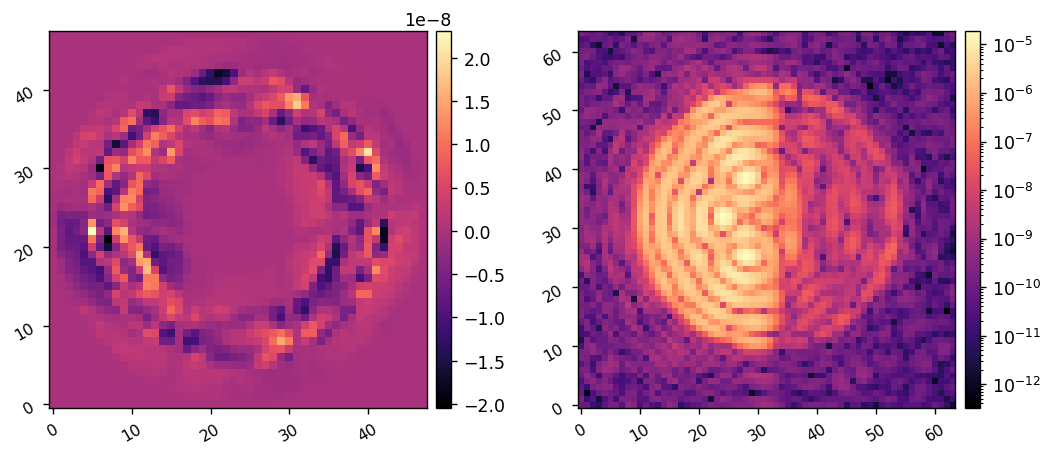

EFC completed in 10.704 sec.


In [26]:
reload(efc)

hlci = init()

commands, efields = efc.run_efc_perfect(hlci, control_matrix, dh_mask, iterations=10, display=True)

# Run EFC with PWP

Beginning closed-loop EFC simulation.
	Running iteration 1/5.


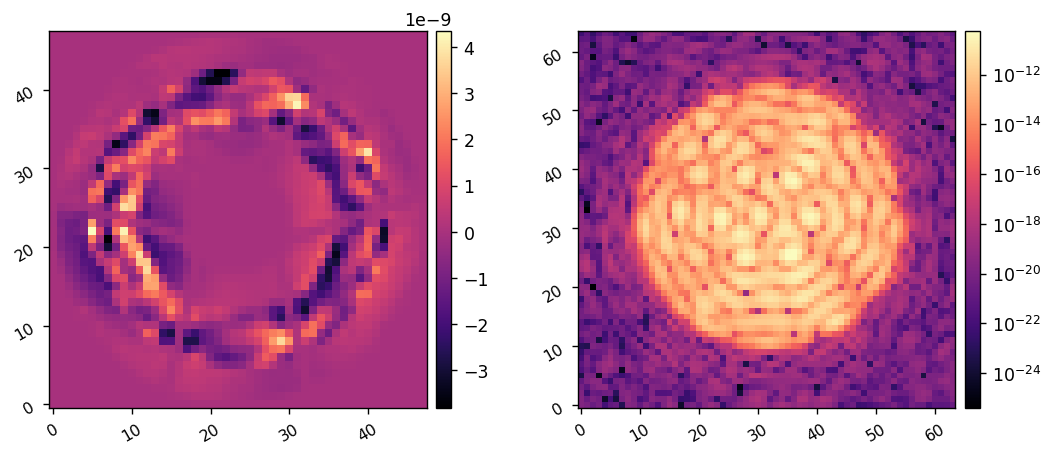

	Running iteration 2/5.


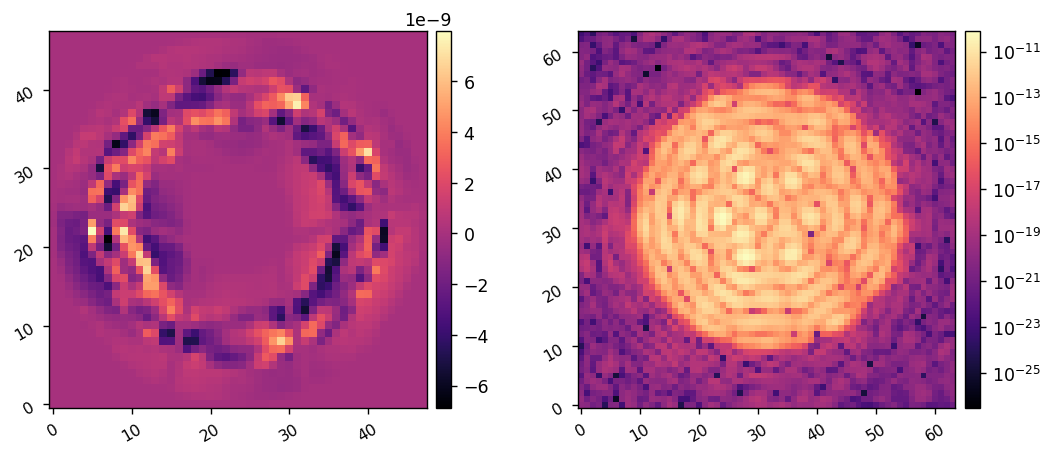

	Running iteration 3/5.


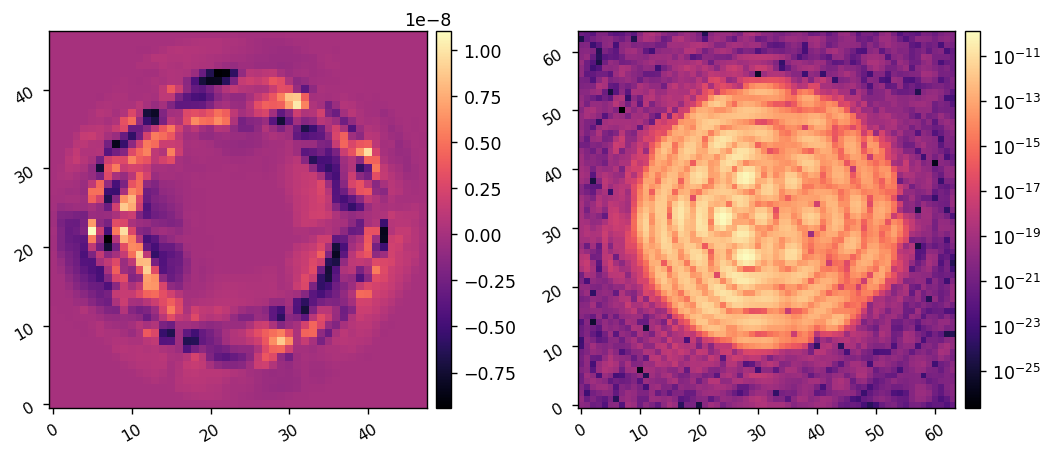

	Running iteration 4/5.


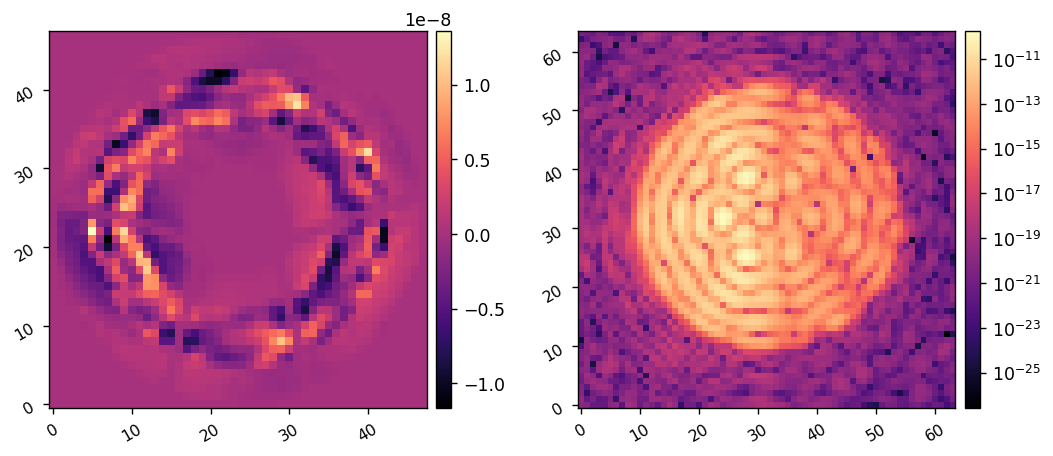

	Running iteration 5/5.


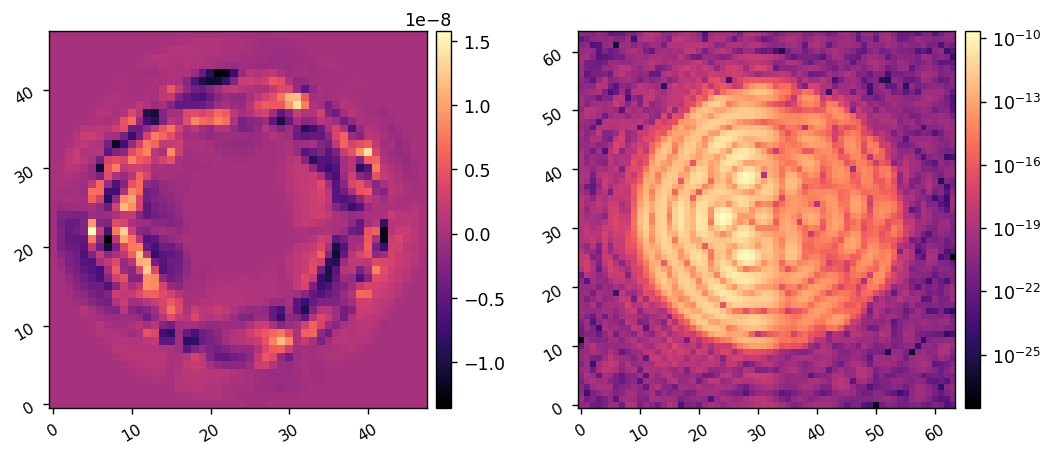

EFC completed in 19.840 sec.


In [27]:
reload(efc)

hlci = init()

commands, efields, images = efc.run_efc_pwp(hlci, control_matrix, jac, probes, dh_mask, iterations=5, display=True)